# 3D trajectory

In this notebook, we construct the 3D trajectories of inner droplets by combining the X-Y plane tracking results and the simultaneous stage positions.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from skimage import io
from IPython.display import clear_output
import dufte
plt.style.use(dufte.style)
from fit_circle_utils import fit_sphere
from myImageLib import bestcolor
from utils import *
from corrLib import readdata

## 1 Generate trajectories 

### 1.1 Construct xyz-traj

- load xy from traj.csv and z from StagePosition.txt

In [46]:
data_folder = '/home/zhengyang/data/DE'
date = '07202021'
subfolder = '1st-drop-tracking/2021-07-20_16h50m22s'

folder = os.path.join(data_folder, date, subfolder)
stagePosition = pd.read_csv(os.path.join(folder, 'StagePosition.txt'), delimiter='\t',
                            names=['name', 'x', 'y', 'z', 'UK1', 'UK2'])

xyPosition = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'traj.csv'))

xyPosition = xyPosition.set_index('filename')
stagePosition = stagePosition.set_index('name')

- convert xy from pixel to um and combine xyz

In [47]:
mpp = 0.1
ind = intersection(xyPosition.index, stagePosition.index) # find overlap frames
xyPosition = xyPosition.loc[ind] # slice xy data
xyPosition['x'] *= mpp # apply mpp
xyPosition['y'] *= mpp # apply mpp
xyPosition = xyPosition.assign(z=stagePosition['z'].loc[ind])  # concatenate z data to xy data

- save xyz to file

In [48]:
xyz_traj = xyPosition[['x', 'y', 'z']]
xyz_traj.to_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'), float_format='%.1f')

#### Batch

In [29]:
log = pd.read_csv(os.path.join('../../Data', 'main_log.csv'), header=[0,1])
slog = log.loc[(log[('analysis', '2D-trajectory')]==1)&(log[('analysis', '3D-trajectory')]==0)]
slog

params                                                      analysis  \
       Date                               Subfolder  BC  MPP FPS       ID   
8   7202021  1st-drop-tracking/2021-07-20_16h34m28s  32  0.1  30      8.7   
9   7202021  1st-drop-tracking/2021-07-20_16h35m47s  32  0.1  30      8.9   
11  7202021  1st-drop-tracking/2021-07-20_16h43m54s  32  0.1  30      8.9   
12  7202021  1st-drop-tracking/2021-07-20_16h44m58s  32  0.1  30      9.2   
13  7202021  1st-drop-tracking/2021-07-20_16h47m59s  32  0.1  30      9.0   
14  7202021  1st-drop-tracking/2021-07-20_16h50m22s  32  0.1  30      9.6   

                                                       Visual                \
      OD     a     b   c 2D-trajectory 3D-trajectory 2D-image 3D-projection   
8   67.6  51.5  51.3 NaN           1.0           0.0      0.0           0.0   
9   65.1  52.2  51.4 NaN           1.0           0.0      0.0           0.0   
11  65.8  52.1  51.6 NaN           1.0           0.0      0.0           0.0   
12  66.4  52.4  50.4 NaN           1.0           0.0      0.0           0.0   
13  68.9  52.5  51.8 NaN           1.0           0.0      0.0           0.0   
14  70.8  51.3  51.2 NaN           1.0           0.0      0.0           0.0   

              
   3D-outRef  
8        0.0  
9        0.0  
11       0.0  
12       0.0  
13       0.0  
14       0.0

In [30]:
data_folder = '/home/zhengyang/data/DE'
for num, i in slog.iterrows():    
    date = '{:08d}'.format(i[('params', 'Date')])
    subfolder = i[('params', 'Subfolder')]
    folder = os.path.join(data_folder, date, subfolder)
    mpp = float(i['params', 'MPP'])
    if os.path.exists(os.path.join(folder, 'StagePosition.txt')) == True:
        stagePosition = pd.read_csv(os.path.join(folder, 'StagePosition.txt'), delimiter='\t',
                                    names=['name', 'x', 'y', 'z', 'UK1', 'UK2'])
    else:
        continue
    xyPosition = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'traj.csv'))
    xyPosition = xyPosition.set_index('filename')
    stagePosition = stagePosition.set_index('name')

    ind = intersection(xyPosition.index, stagePosition.index) # find overlap frames
    xyPosition = xyPosition.loc[ind] # slice xy data
    xyPosition['x'] *= mpp # apply mpp
    xyPosition['y'] *= mpp # apply mpp
    xyPosition = xyPosition.assign(z=stagePosition['z'].loc[ind])  # concatenate z data to xy data

    xyz_traj = xyPosition[['x', 'y', 'z']]
    xyz_traj.to_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'), float_format='%.1f')

### 1.2 Spherical coordinates

The inner droplets mostly slide on the spherical surfaces of outer droplets. This makes the motions of the inner droplets effectively 2D, and can be better described in spherical coordinates. Here, I convert the xyz data into (r, theta, phi).

- determine outer drop z position

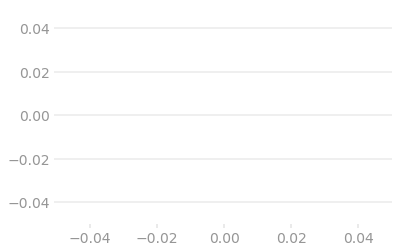

In [35]:
traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'))
# read a, b, r, ri from main_log
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
sublog = log.loc[log[('params', 'Subfolder')]==subfolder]
r = sublog[('analysis', 'OD')]/2; ri = sublog[('analysis', 'ID')]/2
a = sublog[('analysis', 'a')]; b = sublog[('analysis', 'b')]

c = fit_for_outer_drop_z(a, b, r, ri, traj)

- convert:
    - $x, y, z$ -> $x_r, y_r, z_r$
    - $R^2 = x_r^2 + y_r^2 + z_r^2$
    - $\theta = \frac{y_r}{|y_r|}\arctan\frac{y_r}{x_r}$
    - $\phi = \arctan\frac{z_r}{\sqrt{x_r^2+y_r^2}}$

In [29]:
xr = traj['x'] - float(a)
yr = traj['y'] - float(b)
zr = traj['z'] - float(c)

In [30]:
R = (xr**2 + yr**2 + zr**2) ** 0.5
theta = np.sign(yr) * np.arctan(yr/xr)
phi = np.arctan(zr/(xr**2+yr**2)**0.5)

Text(0, 0.5, '$\\theta$, $\\phi$')

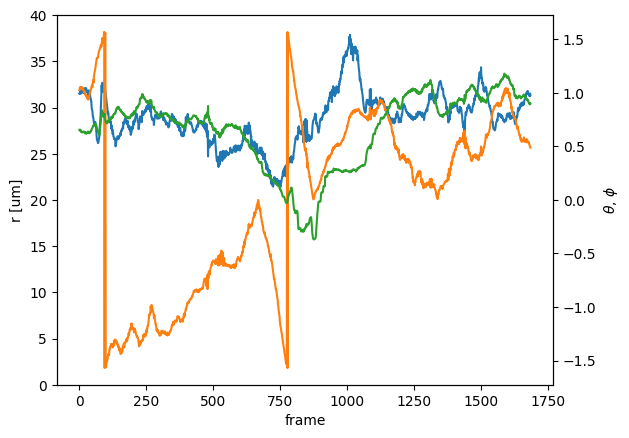

In [37]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(R, label='r')
ax.set_ylim([0, 40])
ax.set_xlabel('frame')
ax.set_ylabel('r [um]')
ax1 = ax.twinx()
ax1.plot(theta, color=bestcolor(1))
ax1.plot(phi, color=bestcolor(2))
ax1.set_ylabel('$\\theta$, $\phi$')

## 2 Visualize the trajectory 

In [49]:
xyz_traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv')).set_index('filename')
mpp = 0.1 # microns per pixel

### 2.1 In 2D (2d-image.jpg)

In [50]:
image_folder = os.path.join(folder, 'images')
img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyz_traj.index[-1])))
traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv')) / 0.1
plot_traj_overlay(traj, img)
fig.savefig(os.path.join(folder, 'crop_HoughCircles', '2d-image.jpg'))

#### batch

In [45]:
log = pd.read_csv(os.path.join('../../Data', 'main_log.csv'), header=[0,1])
slog = log.loc[(log[('analysis', '3D-trajectory')]==1)&(log[('Visual', '2D-image')]==0)]
slog

Empty DataFrame
Columns: [(params, Date), (params, Subfolder), (params, BC), (params, MPP), (params, FPS), (analysis, ID), (analysis, OD), (analysis, a), (analysis, b), (analysis, c), (analysis, 2D-trajectory), (analysis, 3D-trajectory), (Visual, 2D-image), (Visual, 3D-projection), (Visual, 3D-outRef)]
Index: []

In [43]:
for num, i in slog.iterrows():
    date = '{:08d}'.format(i[('params', 'Date')])
    subfolder = i[('params', 'Subfolder')]
    folder = os.path.join(data_folder, date, subfolder)
    
    xyz_traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv')).set_index('filename')
    image_folder = os.path.join(folder, 'images')
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyz_traj.index[-1])))    
    mpp = float(i['params', 'MPP'])
    
    fig = plot_traj_overlay(xyz_traj/mpp, img)
    fig.savefig(os.path.join(folder, 'crop_HoughCircles', '2d-image.jpg'))
    plt.close()

### 2.2 In 3D

(0.0, 52.690000000000005)

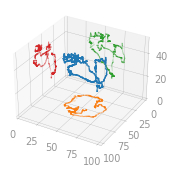

In [48]:
# draw projections

fig = plt.figure(dpi=50)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_traj.x, xyz_traj.y, xyz_traj.z, 
           s=1)
ax.scatter(xyz_traj.x, xyz_traj.y, 0, 
       s=0.5, alpha=0.2)
ax.scatter(xyz_traj.x, 0, xyz_traj.z, 
       s=0.5, alpha=0.2)
ax.scatter(0, xyz_traj.y, xyz_traj.z, 
       s=0.5, alpha=0.2)

ax.set_xlim((0, img.shape[0]*mpp))
ax.set_ylim((img.shape[1]*mpp, 0))
ax.set_zlim((0, 1.1*xyz_traj.z.max()))

## 3 3D trajectory animation 

### 3.1 Fixed view, with projections (3d-traj-animation.avi)

![3d traj projection demo](demo/3d-traj-projection-demo.gif)

In [51]:
# trajectory animation and video
mpp = 0.1 # microns per pixel
interval = 10 # plot skip
save_folder = os.path.join(folder, 'crop_HoughCircles', '3d-traj-animation')
image_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

for i in range(len(xyPosition)):
    if i % interval != 0:
        continue
    print('{0:d}/{1:d}, {2:.2f}%'.format(i, len(xyPosition), i/len(xyPosition)*100))
    clear_output(wait=True)
    xyPosition1 = xyz_traj[:i+1]
    zeros = np.zeros(len(xyPosition1))
    fig = plt.figure(figsize=(4, 2), dpi=150)
    ax = fig.add_axes([0,0,0.5,1], projection='3d')
    ax.plot(xyPosition1.x, xyPosition1.y, xyPosition1.z)

    ax.plot(xyPosition1.x, xyPosition1.y, zeros, ls=':')
    ax.plot(xyPosition1.x, zeros, xyPosition1.z, ls=':')
    ax.plot(zeros, xyPosition1.y, xyPosition1.z, ls=':')
    
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyPosition1.index[-1])))
    
    # determine axis limits automatically
    ax.set_xlim((0, img.shape[0]*mpp))
    ax.set_ylim((img.shape[1]*mpp, 0))
    ax.set_zlim((0, 1.1*xyPosition1.z.max()))
    
    ax2 = fig.add_axes([0.5,0,0.5,1])    
    ax2.imshow(img, cmap='gray')
    ax2.plot(xyPosition1.x.iloc[-1]/mpp, xyPosition1.iloc[-1].y/mpp, 
             mec='red', ls='', marker='o', mfc=(0,0,0,0), markersize=11)
    ax2.axis('off')
    fig.savefig(os.path.join(save_folder, '{:08d}.jpg'.format(xyPosition1.index[-1])))
    plt.close()

1800/1806, 99.67%


### 3.2 Rotating view, reference outer droplet, no projections (3d-traj-RVRef.avi)

Show the relative position between inner and outer droplets. 

![outer ref demo](demo/outer-ref-demo.gif)

#### 3.2.1 Determine the position of outer droplet
- Measure a, b and r from image, find c which gives least deviation from surface (so far the best) 


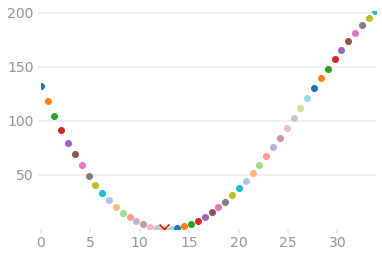

In [29]:
traj = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'))
# read a, b, r, ri from main_log
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
sublog = log.loc[log[('params', 'Subfolder')]==subfolder]
r = sublog[('analysis', 'OD')]/2; ri = sublog[('analysis', 'ID')]/2
a = sublog[('analysis', 'a')]; b = sublog[('analysis', 'b')]

c = fit_for_outer_drop_z(a, b, r, ri, traj)

#### 3.2.2 Rotation view, outer drop reference (3d-traj-RVRef.avi)

<font color='red'> NOTE: run one of the cells in 3.2.1 to get p before running the cell below

In [30]:
save_folder = os.path.join(folder, 'crop_HoughCircles', '3d-traj-RVRef')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
a = float(a); b = float(b); c = float(c); r = float(r)

for n, i in traj.iterrows():
    if n % 10 == 0:
        print('{0:d}/{1:d}, {2:.2f}%'.format(n, len(traj), n/len(traj)*100))
        fig = plt.figure(figsize=(3, 3), dpi=300)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([a-r, a+r])
        ax.set_ylim([b+r, b-r])        
        ax.set_zlim([c-r, c+r])
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = r*np.cos(u)*np.sin(v) + a
        y = r*np.sin(u)*np.sin(v) + b
        z = r*np.cos(v) + c
        ax.plot_wireframe(x, y, z, color=(1, 0, 0, 0.3), lw=0.5, ls='--')
        ax.axis('off')
        ax.plot(traj.x[:n], traj.y[:n], traj.z[:n], color='black', lw=0.5, ls='-.')
        ax.scatter(traj.x[n], traj.y[n], traj.z[n], s=20, marker='o', color=bestcolor(1))
        ax.view_init(30, 360*n/len(traj))
        fig.savefig(os.path.join(save_folder, '{:04d}.jpg'.format(n)))
        plt.close()
        clear_output(wait=True)

1800/1805, 99.72%
